In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.10.0+cu111


In [ ]:
%%capture
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install ogb

In [ ]:
import torch_geometric 
import torch_scatter
import torch_sparse
torch_geometric.__version__, torch_scatter.__version__, torch_sparse.__version__

('2.0.3', '2.0.9', '0.6.12')

In [ ]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import show
from bokeh.models import Circle, MultiLine, Range1d
from bokeh.palettes import Oranges8, Blues8, Reds8, Purples8, Viridis8
from bokeh.plotting import figure, from_networkx
from bokeh.transform import linear_cmap
from bokeh.io import output_notebook

import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
output_notebook() 

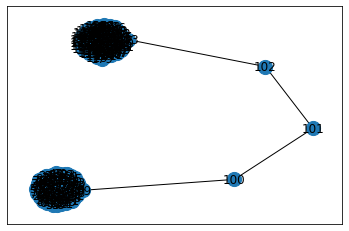

In [ ]:
graph = nx.barbell_graph(100, 3)
options = {
    'node_size': 200,
    'width': 1,
}
nx.draw_networkx(graph, **options)

In [ ]:
print("Total number of graph nodes:", graph.number_of_nodes())
print("Total number of graph edges:", graph.number_of_edges())

Total number of graph nodes: 203
Total number of graph edges: 9904


In [ ]:
src = []
dst = []
for i, j in graph.edges:
    src.append(i)
    dst.append(j)

In [ ]:
anchor_nodes = [4, 120]

degree = []
clustering = []
dst_anchor_1 = []
dst_anchor_2 = []
for node in graph.nodes:
    degree.append(graph.degree(node))
    clustering.append(nx.clustering(graph, node))
    dst_anchor_1.append(nx.shortest_path_length(graph, source=node, target=anchor_nodes[0]))
    dst_anchor_2.append(nx.shortest_path_length(graph, source=node, target=anchor_nodes[1]))
features = pd.DataFrame({"degree": degree,
                         "clustering": clustering,
                         "dst_anchor_1": dst_anchor_1,
                         "dst_anchor_2": dst_anchor_2})

In [ ]:
features = features.reset_index()

In [ ]:
features["label"] = features["index"].apply(lambda x: x<graph.number_of_nodes()//2).astype(np.int32)
features["train_mask"] = False
n_train = 40
train_nodes = np.random.randint(0, features.shape[0]/2, n_train//2).tolist() + np.random.randint(features.shape[0]/2, features.shape[0], n_train//2).tolist()
features.loc[train_nodes, "train_mask"] = True
features["test_mask"] = ~features["train_mask"]
features = features.sample(frac=1)

In [ ]:
features.head()

,index,degree,clustering,dst_anchor_1,dst_anchor_2,label,train_mask,test_mask
123,123,99,1.0000,6,1,0,True,False
129,129,99,1.0000,6,1,0,False,True
165,165,99,1.0000,6,1,0,False,True
136,136,99,1.0000,6,1,0,True,False
42,42,99,1.0000,1,6,1,False,True


In [ ]:
features.sort_values("index")

,index,degree,clustering,dst_anchor_1,dst_anchor_2,label,train_mask,test_mask
0,0,99,1.0000,1,6,1,False,True
1,1,99,1.0000,1,6,1,False,True
2,2,99,1.0000,1,6,1,False,True
3,3,99,1.0000,1,6,1,False,True
4,4,99,1.0000,0,6,1,False,True
...,...,...,...,...,...,...,...,...
198,198,99,1.0000,6,1,0,False,True
199,199,99,1.0000,6,1,0,True,False
200,200,99,1.0000,6,1,0,False,True
201,201,99,1.0000,6,1,0,False,True


In [ ]:
features["train_mask"].sum(), features["test_mask"].sum()

(37, 166)

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
data.edge_index.dtype, data.x.dtype, data.y.dtype, data.train_mask.dtype

Processing...
Done!


(torch.int64, torch.float32, torch.int64, torch.bool)

In [ ]:
from torch_geometric.data import Data
edge_index = torch.Tensor([src, dst]).to(torch.int64)
data = Data(x=torch.Tensor(features[["degree", "clustering", "dst_anchor_1", "dst_anchor_2"]].values),
            edge_index=edge_index,
            y=torch.Tensor(features["label"].values).to(torch.int64),
            train_mask=torch.Tensor(features["train_mask"].values).to(torch.bool),
            test_mask=torch.Tensor(features["test_mask"].values).to(torch.bool))
data

Data(x=[203, 4], edge_index=[2, 9904], y=[203], train_mask=[203], test_mask=[203])

In [ ]:
data.edge_index.dtype, data.x.dtype, data.y.dtype, data.train_mask.dtype

(torch.int64, torch.float32, torch.int64, torch.bool)

In [ ]:
import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F 
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from sklearn.metrics import accuracy_score
import torch_geometric.utils as pyg_utils
torch.manual_seed(123)
import random
random.seed(123)
np.random.seed(123)

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.hid = 16
        self.in_head = 1
        self.out_head = 1
        hidden_dim = 4

        self.lin1 = nn.Linear(in_features=data.x.shape[1], out_features=hidden_dim)
        self.lin2 = nn.Linear(in_features=hidden_dim, out_features=1)
        
        self.conv1 = GATConv(in_channels=hidden_dim, out_channels=hidden_dim)
        
    def forward(self, x, edge_index):  
        edge_index, _ = pyg_utils.add_self_loops(edge_index, num_nodes=x.size(0))              
        x = self.lin1(x)
        x = F.relu(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.lin2(x)
        
        return torch.sigmoid(x)

In [ ]:
model = GNN()
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model(data.x, data.edge_index).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


torch.Size([203, 1])

In [ ]:
data.y[data.train_mask].shape

torch.Size([37])

In [ ]:
pred = model(data.x, data.edge_index)
pred.shape
(pred>0.5).to(torch.int64)
criterion = nn.BCELoss()
criterion(pred[data.train_mask].flatten(), data.y[data.train_mask].to(torch.float))


tensor(0.6933, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
from torch.nn.modules.loss import BCELoss
from sklearn.metrics import accuracy_score
model = GNN()
# model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, verbose=True)

criterion = nn.BCELoss()
def train():
  model.train()
  optimizer.zero_grad()
  pred = model(data.x, data.edge_index)
  loss = criterion(pred[data.train_mask].flatten(), data.y[data.train_mask].to(torch.float))
  loss.backward()
  optimizer.step()
  # scheduler.step(loss)
  train_correct = (pred[data.train_mask]>0.5).to(int).flatten() == data.y[data.train_mask]
  train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
  return loss.item(), train_acc

def test():
  model.eval()
  pred = model(data.x, data.edge_index)
  test_correct = (pred[data.test_mask]>0.5).to(int).flatten() == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

  # test_acc = accuracy_score(data.y[data.test_mask].numpy(), pred.argmax(dim=1)[data.test_mask].numpy())
  return test_acc

In [ ]:
for epoch in range(1, 5000):
  output, acc = train()
  if epoch % 100 == 0:
    print(f"epoch: {epoch:3d}, train_loss: {output:.4f}, train acc: {acc:.2f}, test_acc: {test():.2f}")

epoch: 100, train_loss: 0.6583, train acc: 0.57, test_acc: 0.58
epoch: 200, train_loss: 0.1118, train acc: 0.97, test_acc: 0.99
epoch: 300, train_loss: 0.1064, train acc: 0.97, test_acc: 1.00
epoch: 400, train_loss: 0.1059, train acc: 0.97, test_acc: 1.00
epoch: 500, train_loss: 0.7146, train acc: 0.78, test_acc: 0.99
epoch: 600, train_loss: 0.0086, train acc: 1.00, test_acc: 0.99
epoch: 700, train_loss: 0.0058, train acc: 1.00, test_acc: 0.99
epoch: 800, train_loss: 0.0042, train acc: 1.00, test_acc: 0.99
epoch: 900, train_loss: 0.0032, train acc: 1.00, test_acc: 0.99
epoch: 1000, train_loss: 0.0025, train acc: 1.00, test_acc: 0.99
epoch: 1100, train_loss: 0.0020, train acc: 1.00, test_acc: 0.99
epoch: 1200, train_loss: 0.0017, train acc: 1.00, test_acc: 0.99
epoch: 1300, train_loss: 0.0014, train acc: 1.00, test_acc: 0.99
epoch: 1400, train_loss: 0.0012, train acc: 1.00, test_acc: 0.99
epoch: 1500, train_loss: 0.0010, train acc: 1.00, test_acc: 0.99
epoch: 1600, train_loss: 0.0008, t

In [ ]:
data_correct = (model(data.x, data.edge_index)>0.5).to(int).flatten() == data.y
int(data_correct.sum()) / len(data.y)

0.9950738916256158

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Processing...
Done!


In [ ]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

tensor(1.9452, grad_fn=<NllLossBackward0>)
tensor(0.6871, grad_fn=<NllLossBackward0>)
tensor(0.6525, grad_fn=<NllLossBackward0>)
tensor(0.6417, grad_fn=<NllLossBackward0>)
tensor(0.5493, grad_fn=<NllLossBackward0>)


In [ ]:
torch.exp(model(data)).argmax(dim=1)

tensor([3, 4, 3,  ..., 6, 3, 3])

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8150


In [ ]:
data.y.dtype, dataset[0].y.dtype

(torch.float32, torch.int64)